# Three Steps Analysis

In [ ]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(series):
    """Compute the standard error on a pandas Series."""
    n = series.count()
    return series.std(ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_metrics(df, stage):
    """
    Given a DataFrame of interactions (with a column for the stage and a column for ground_truth),
    compute:
      - Total accuracy (unsure responses, coded as 2, count as incorrect)
      - Accuracy on non-unsure responses ("NotUnsureAcc")
      - Unsure rate
      - Utility (0 if unsure; 1 if correct; -1 if incorrect)
    Returns also the computed utility as a Series.
    """
    preds = df[stage]
    # Total accuracy: count unsure as incorrect.
    correct_all = ((preds != 2) & (preds == df['ground_truth'])).astype(float)
    total_acc_mean = correct_all.mean()
    total_acc_se = compute_se(correct_all)
    
    # Accuracy on non-unsure responses.
    non_unsure = preds != 2
    if non_unsure.sum() > 0:
        correct_non_unsure = (df.loc[non_unsure, stage] == df.loc[non_unsure, 'ground_truth']).astype(float)
        acc_mean = correct_non_unsure.mean()
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan

    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_mean = unsure_indicator.mean()
    unsure_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; else 1 if correct, -1 if incorrect.
    # (i.e., 1 - 2*abs(pred - ground_truth))
    def calc_util(row):
        p = row[stage]
        gt = row['ground_truth']
        return 0 if p == 2 else 1 - 2*abs(p - gt)
    utility = df.apply(calc_util, axis=1)
    util_mean = utility.mean()
    util_se = compute_se(utility)
    
    return total_acc_mean, total_acc_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, utility

# ---------------------------
# Settings and Directories
# ---------------------------
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0',
    'vf_numeric_qwen2.5_vizwiz_q10_i10_s0',
    'vf_descriptive_qwen2.5_vizwiz_q10_i10_s0',
    'combined12_llava1.5_with_image_q20_i10_s0',
    'combined123_llava1.5_with_image_q20_i10_s0',
]
USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# To store scores and confusion matrices across settings
all_setting_scores = []
all_confusion_matrices = []
consistent_choice_threshold = 0.9  # 90% threshold
df_map = {}

# ---------------------------
# Process Each Setting via DataFrame
# ---------------------------
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Create a list of records (each record is an interaction)
    records = []
    for file in files:
        batch_id = os.path.basename(file).split('.')[0]
        with open(file) as f:
            batch_data = json.load(f)
        # Each file contains sessions for multiple users.
        for user_id, session in batch_data.items():
            interactions = session['interactions']
            for interaction in interactions:
                rec = {
                    'user_id': user_id,
                    'batch': batch_id,
                    'question_i': interaction['question_i'],
                    'answeronly': interaction['user_selections'].get('answeronly'),
                    'withexplanation': interaction['user_selections'].get('withexplanation'),
                    'withexplanationquality': interaction['user_selections'].get('withexplanationquality'),
                    # Ground truth: defined as 1 - prediction_is_correct.
                    'ground_truth': 1 - interaction['question']['prediction_is_correct']
                }
                records.append(rec)
    
    # Build DataFrame from the records.
    df = pd.DataFrame(records)
    print(f"Found {df['user_id'].nunique()} users and {len(df)} interactions for setting '{setting}'.")
    
    # ---------------------------
    # Filter Users Based on Consistency
    # ---------------------------
    # For each user, look at all responses across all stages and drop users
    # where one response (0, 1, or 2) comprises ≥90% of their responses.
    def user_is_valid(group):
        responses = pd.concat([group['answeronly'], group['withexplanation'], group['withexplanationquality']])
        if responses.empty:
            return False
        norm_counts = responses.value_counts(normalize=True)
        if norm_counts.max() >= consistent_choice_threshold:
            # If desired, you could print which user is filtered out.
            # print(f"User {group.name} filtered out; response distribution: {norm_counts.to_dict()}")
            return False
        return True

    df_valid = df.groupby('user_id').filter(user_is_valid)

    if df_valid.empty:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue
        
    # ---------------------------
    # Filter Batches with More Than 30 Annotations
    # ---------------------------
    # For each batch, if it has been annotated more than 30 times (i.e. more than three users,
    # assuming each user annotates about 10 interactions), print the annotation count
    # and then shorten the batch to include only the first 30 annotations.
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count > 30:
            print(f"Batch {batch} has been annotated {count} times, exceeding 30 annotations. Shortening to first 30 annotations.")
    # Group by 'batch' and take only the first 30 entries for each batch
    df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
    print(f"{df_valid['user_id'].nunique()} users remain after filtering; {len(df_valid)} interactions remain.")
    
    
    # Indicate which batches need to add users
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count % 10: raise ValueError('# Annotation should be divisible by 10, but found not??')
        count = count // 10
        if count > 3:
            raise ValueError(f"After filtering, # users taking the batch should not > 3??")
        diff = 3 - count
        if diff != 0:
            print(f"Batch {batch} need {diff} more users to annotate.")
            
    # Add df to the df_map for later use.
    df_map[setting] = df_valid
    
    
    # ---------------------------
    # Compute Metrics for Each Stage Using DataFrames
    # ---------------------------
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stages = ['answeronly', 'withexplanation', 'withexplanationquality']
    metrics = {}
    utilities = {}
    csv_prints = []
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    for stage, name in zip(stages, stage_names):
        tot_acc, tot_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, util_series = compute_metrics(df_valid, stage)
        metrics[stage] = {
            'total_accuracy_mean': tot_acc,
            'total_accuracy_se': tot_se,
            'accuracy_mean': acc_mean,
            'accuracy_se': acc_se,
            'unsure_rate_mean': unsure_mean,
            'unsure_rate_se': unsure_se,
            'utility_mean': util_mean,
            'utility_se': util_se
        }
        utilities[stage] = util_series
        print(f"{name:<25}\t{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%\t"
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%\t"
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%\t"
              f"{util_mean:+.3f} ± {util_se:.3f}")
        csv_prints.append(f"{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%, "
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%, "
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%, "
              f"{util_mean:+.3f} ± {util_se:.3f}")
        
    print(", ".join(csv_prints))

    # ---------------------------
    # Utility Gains Between Stages
    # ---------------------------
    gain_explanation = utilities['withexplanation'] - utilities['answeronly']
    gain_quality = utilities['withexplanationquality'] - utilities['withexplanation']
    expl_gain_mean = gain_explanation.mean()
    expl_gain_se = gain_explanation.std(ddof=1) / np.sqrt(len(gain_explanation)) if len(gain_explanation) > 1 else 0
    qual_gain_mean = gain_quality.mean()
    qual_gain_se = gain_quality.std(ddof=1) / np.sqrt(len(gain_quality)) if len(gain_quality) > 1 else 0
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    print(f"Explanation\t {metrics['withexplanation']['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {metrics['withexplanationquality']['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")
    
    # ---------------------------
    # Compute Confusion Matrix and M1–M4 Scores
    # ---------------------------
    # Compute utility for withexplanation and withexplanationquality directly.
    def compute_utility(val, gt):
        return 0 if val == 2 else 1 - 2*abs(val-gt)
    
    df_valid['util_withexplanation'] = df_valid.apply(lambda row: compute_utility(row['withexplanation'], row['ground_truth']), axis=1)
    df_valid['util_withexplanationquality'] = df_valid.apply(lambda row: compute_utility(row['withexplanationquality'], row['ground_truth']), axis=1)
    
    # For the confusion matrix, map utilities to indices: -1 -> 0, 0 -> 1, 1 -> 2.
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']
    
    try:
        cm = np.zeros((3, 3), dtype=int)
        for _, row in df_valid.iterrows():
            u2 = row['util_withexplanation']
            u3 = row['util_withexplanationquality']
            cm[mapping[u2], mapping[u3]] += 1
        cm_transposed = cm.T
    except Exception as e:
        print(f"Error computing confusion matrix or M1–M4 scores: {e}")
        print(f"This would be expected if setting {setting} is combined12 or combined123.")
        continue
        
    print(f"\nSetting: {setting} Step 2 -> Step 3 (transposed)")
    print("\t\t" + "\t".join(label_names))
    for i, label in enumerate(label_names):
        row_values = "\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_values}")
    
    # Compute M1–M4 using counts from the confusion matrix.
    def count_transitions(val2, val3):
        return ((df_valid['util_withexplanation'] == val2) & (df_valid['util_withexplanationquality'] == val3)).sum()
    
    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    print(f"{m1:.2%}, {m2:.2%}, {m3:.2%}, {m4:.2%}, {m3-m4:.2%}")

    
    # ---------------------------
    # Print Examples Where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    examples = df_valid[
        (df_valid['withexplanation'] != 2) &
        (df_valid['withexplanation'] == df_valid['ground_truth']) &
        (df_valid['withexplanationquality'] != 2) &
        (df_valid['withexplanationquality'] != df_valid['ground_truth'])
    ]
    if not examples.empty:
        for idx, row in examples.head(5).iterrows():
            print(row.to_json())
    else:
        print("No examples found.")
    
    # ---------------------------
    # Plot: Confusion Matrix and M1–M4 Scores for the Current Setting
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Plot confusion matrix
    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\n(WithExplanation -> WithExplanationQuality)")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    # Plot M1–M4 scores as text.
    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                  f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                  f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                  f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")
    plt.tight_layout()
    plt.show()
    
    # Save scores and confusion matrix for later comparison/plotting.
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    all_confusion_matrices.append((setting, cm_transposed))

# ---------------------------
# Plot Grouped Bar Chart for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    df_scores = df_scores.set_index("SettingShort")
    
    # Transpose so that rows become score types.
    df_scores_T = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate",
                             "Correct Loss Rate", "Recovery Gap"]].transpose()
    
    ax = df_scores_T.plot(kind='bar', figsize=(12, 6))
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("Scores by Score Type Across Settings")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title="Setting", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------------------------
# Plot a Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
                
    # Turn off any extra axes.
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()


In [ ]:
# ---------------------------
# Updated Bar Plot for Resolution Rate and Error Recovery Rate (Separate Plots)
# with Larger Text, Renamed x‑Tick Labels, and Specified Y‑Range for Resolution Rate Plot
# ---------------------------
if all_setting_scores:
    import matplotlib.ticker as mtick
    # Create a DataFrame from the scores and simplify the setting names.
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores = df_scores.set_index("SettingShort")
    df_scores.index.name = None  # Remove the index label from the x-axis.
    
    # Define a mapping from the abbreviated setting names to more natural names.
    rename_mapping = {
        'vf_numeric': 'Numeric VF',
        'contr_numeric': 'Numeric CONTR',
        'showbothmetrics': 'Both Metrics (Numeric)',
        'avg_vf_contr_numeric': 'Average VF/CONTR (Numeric)',
        'showbothmetrics_descriptive': 'Both Metrics (Descriptive)',
        'vf_descriptive': 'Descriptive VF',
        'contr_descriptive': 'Descriptive CONTR'
    }
    
    # Extract the two metrics separately.
    resolution = df_scores["Resolution Rate"]
    error_recovery = df_scores["Error Recovery Rate"]
    
    # Set up subplots for each metric.
    fig, axes = plt.subplots(ncols=2, figsize=(12, 7))
    
    # Plot Resolution Rate.
    resolution.plot(kind="bar", ax=axes[0], color="skyblue")
    axes[0].set_title("Resolution Rate Across Settings", fontsize=16, fontweight="bold")
    axes[0].set_ylabel("Resolution Rate (%)", fontsize=16)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    axes[0].set_xlabel("")  # Remove the x-axis label
    axes[0].tick_params(axis="both", labelsize=12)
    # Replace x tick labels using the mapping.
    new_labels = [rename_mapping.get(label.get_text(), label.get_text()) 
                  for label in axes[0].get_xticklabels()]
    axes[0].set_xticklabels(new_labels, rotation=45, ha="right", fontsize=16)
    axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # Set custom y-axis range
    axes[0].set_ylim(0.6, 1)
    # Annotate each bar (multiplying value by 100 for percentage display).
    for rect in axes[0].patches:
        height = rect.get_height()
        axes[0].text(rect.get_x() + rect.get_width()/2, height, f"{height*100:.1f}%",
                     ha="center", va="bottom", fontsize=14)
    
    # Plot Error Recovery Rate.
    error_recovery.plot(kind="bar", ax=axes[1], color="lightgreen")
    axes[1].set_title("Error Recovery Rate Across Settings", fontsize=16, fontweight="bold")
    axes[1].set_ylabel("Error Recovery Rate (%)", fontsize=16)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)
    axes[1].set_xlabel("")  # Remove the x-axis label
    axes[1].tick_params(axis="both", labelsize=12)
    new_labels = [rename_mapping.get(label.get_text(), label.get_text()) 
                  for label in axes[1].get_xticklabels()]
    axes[1].set_xticklabels(new_labels, rotation=45, ha="right", fontsize=16)
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[1].set_ylim(0, 0.35)
    for rect in axes[1].patches:
        height = rect.get_height()
        axes[1].text(rect.get_x() + rect.get_width()/2, height, f"{height*100:.1f}%",
                     ha="center", va="bottom", fontsize=14)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Store df_map to a file for later use.
import pickle
for setting, df in df_map.items():
    # only keep the columns we need
    df_map[setting] = df[['user_id', 'batch', 'question_i', 'answeronly', 'withexplanation', 'withexplanationquality', 'ground_truth']]
with open('df_map.pkl', 'wb') as f:
    pickle.dump(df_map, f)

# Combined123 Analysis

In [17]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# We do not want to include the following prolific IDs in our analysis.
excluded_ids = ['66d4ec6fe6d7a979e98b5ff3']

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(series):
    """Compute the standard error on a pandas Series."""
    n = series.count()
    return series.std(ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_metrics(df, stage):
    """
    Given a DataFrame of interactions (with a column for the stage and a column for ground_truth),
    compute:
      - Total accuracy (unsure responses, coded as 2, count as incorrect)
      - Accuracy on non-unsure responses ("NotUnsureAcc")
      - Unsure rate
      - Utility (0 if unsure; 1 if correct; -1 if incorrect)
    Returns also the computed utility as a Series.
    """
    preds = df[stage]
    # Total accuracy: count unsure as incorrect.
    correct_all = ((preds != 2) & (preds == df['ground_truth'])).astype(float)
    total_acc_mean = correct_all.mean()
    total_acc_se = compute_se(correct_all)
    
    # Accuracy on non-unsure responses.
    non_unsure = preds != 2
    if non_unsure.sum() > 0:
        correct_non_unsure = (df.loc[non_unsure, stage] == df.loc[non_unsure, 'ground_truth']).astype(float)
        acc_mean = correct_non_unsure.mean()
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan

    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_mean = unsure_indicator.mean()
    unsure_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; else 1 if correct, -1 if incorrect.
    # (i.e., 1 - 2*abs(pred - ground_truth))
    def calc_util(row):
        p = row[stage]
        gt = row['ground_truth']
        return 0 if p == 2 else 1 - 2*abs(p - gt)
    utility = df.apply(calc_util, axis=1)
    util_mean = utility.mean()
    util_se = compute_se(utility)
    
    return total_acc_mean, total_acc_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, utility

# ---------------------------
# Settings and Directories
# ---------------------------
settings = [
    'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'vf_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prod_as_vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prod_as_contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_vizwiz_better_sampled_q10_i10_s0',    
]
USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# To store scores and confusion matrices across settings
all_setting_scores = []
all_confusion_matrices = []
consistent_choice_threshold = 0.9  # 90% threshold
df_map = {}

# ---------------------------
# Process Each Setting via DataFrame
# ---------------------------
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Create a list of records (each record is an interaction)
    records = []
    for file in files:
        batch_id = os.path.basename(file).split('.')[0]
        with open(file) as f:
            batch_data = json.load(f)
        # Each file contains sessions for multiple users.
        for user_id, session in batch_data.items():
            interactions = session['interactions']
            for interaction in interactions:
                rec = {
                    'user_id': user_id,
                    'batch': batch_id,
                    'question_i': interaction['question_i'],
                    'answeronly': interaction['user_selections'].get('answeronly'),
                    'withexplanation': interaction['user_selections'].get('withexplanation'),
                    'withexplanationquality': interaction['user_selections'].get('withexplanationquality'),
                    # Ground truth: defined as 1 - prediction_is_correct.
                    'ground_truth': 1 - interaction['question']['prediction_is_correct']
                }
                # Exclude users with excluded IDs.
                if user_id in excluded_ids:
                    continue
                records.append(rec)
    
    # Build DataFrame from the records.
    df = pd.DataFrame(records)
    print(f"Found {df['user_id'].nunique()} users and {len(df)} interactions for setting '{setting}'.")
    
    # ---------------------------
    # Filter Users Based on Consistency
    # ---------------------------
    # For each user, look at all responses across all stages and drop users
    # where one response (0, 1, or 2) comprises ≥90% of their responses.
    def user_is_valid(group):
        responses = pd.concat([group['answeronly'], group['withexplanation'], group['withexplanationquality']])
        if responses.empty:
            return False
        norm_counts = responses.value_counts(normalize=True)
        if norm_counts.max() >= consistent_choice_threshold:
            # If desired, you could print which user is filtered out.
            # print(f"User {group.name} filtered out; response distribution: {norm_counts.to_dict()}")
            return False
        return True

    df_valid = df.groupby('user_id').filter(user_is_valid)

    if df_valid.empty:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue
        
    # ---------------------------
    # Filter Batches with More Than 30 Annotations
    # ---------------------------
    # For each batch, if it has been annotated more than 30 times (i.e. more than three users,
    # assuming each user annotates about 10 interactions), print the annotation count
    # and then shorten the batch to include only the first 30 annotations.
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count > 30:
            print(f"Batch {batch} has been annotated {count} times, exceeding 30 annotations. Shortening to first 30 annotations.")
    # Group by 'batch' and take only the first 30 entries for each batch
    df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
    print(f"{df_valid['user_id'].nunique()} users remain after filtering; {len(df_valid)} interactions remain.")
    
    
    # Indicate which batches need to add users
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count % 10: raise ValueError('# Annotation should be divisible by 10, but found not??')
        count = count // 10
        if count > 3:
            raise ValueError(f"After filtering, # users taking the batch should not > 3??")
        diff = 3 - count
        if diff != 0:
            print(f"Batch {batch} need {diff} more users to annotate.")
            
    # Add df to the df_map for later use.
    df_map[setting] = df_valid
    
    
    # ---------------------------
    # Compute Metrics for Each Stage Using DataFrames
    # ---------------------------
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stages = ['answeronly', 'withexplanation', 'withexplanationquality']
    metrics = {}
    utilities = {}
    csv_prints = []
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    for stage, name in zip(stages, stage_names):
        tot_acc, tot_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, util_series = compute_metrics(df_valid, stage)
        metrics[stage] = {
            'total_accuracy_mean': tot_acc,
            'total_accuracy_se': tot_se,
            'accuracy_mean': acc_mean,
            'accuracy_se': acc_se,
            'unsure_rate_mean': unsure_mean,
            'unsure_rate_se': unsure_se,
            'utility_mean': util_mean,
            'utility_se': util_se
        }
        utilities[stage] = util_series
        print(f"{name:<25}\t{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%\t"
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%\t"
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%\t"
              f"{util_mean:+.3f} ± {util_se:.3f}")
        csv_prints.append(f"{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%, "
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%, "
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%, "
              f"{util_mean:+.3f} ± {util_se:.3f}")
        
    print(", ".join(csv_prints))

    # ---------------------------
    # Utility Gains Between Stages
    # ---------------------------
    gain_explanation = utilities['withexplanation'] - utilities['answeronly']
    gain_quality = utilities['withexplanationquality'] - utilities['withexplanation']
    expl_gain_mean = gain_explanation.mean()
    expl_gain_se = gain_explanation.std(ddof=1) / np.sqrt(len(gain_explanation)) if len(gain_explanation) > 1 else 0
    qual_gain_mean = gain_quality.mean()
    qual_gain_se = gain_quality.std(ddof=1) / np.sqrt(len(gain_quality)) if len(gain_quality) > 1 else 0
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    print(f"Explanation\t {metrics['withexplanation']['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {metrics['withexplanationquality']['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")
    
    # ---------------------------
    # Compute Confusion Matrix and M1–M4 Scores
    # ---------------------------
    # Compute utility for withexplanation and withexplanationquality directly.
    def compute_utility(val, gt):
        return 0 if val == 2 else 1 - 2*abs(val-gt)
    
    df_valid['util_withexplanation'] = df_valid.apply(lambda row: compute_utility(row['withexplanation'], row['ground_truth']), axis=1)
    df_valid['util_withexplanationquality'] = df_valid.apply(lambda row: compute_utility(row['withexplanationquality'], row['ground_truth']), axis=1)
    
    # For the confusion matrix, map utilities to indices: -1 -> 0, 0 -> 1, 1 -> 2.
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']
    
    try:
        cm = np.zeros((3, 3), dtype=int)
        for _, row in df_valid.iterrows():
            u2 = row['util_withexplanation']
            u3 = row['util_withexplanationquality']
            cm[mapping[u2], mapping[u3]] += 1
        cm_transposed = cm.T
    except Exception as e:
        print(f"Error computing confusion matrix or M1–M4 scores: {e}")
        print(f"This would be expected if setting {setting} is combined12 or combined123.")
        continue
        
    print(f"\nSetting: {setting} Step 2 -> Step 3 (transposed)")
    print("\t\t" + "\t".join(label_names))
    for i, label in enumerate(label_names):
        row_values = "\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_values}")
    
    # Compute M1–M4 using counts from the confusion matrix.
    def count_transitions(val2, val3):
        return ((df_valid['util_withexplanation'] == val2) & (df_valid['util_withexplanationquality'] == val3)).sum()
    
    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    print(f"{m1:.2%}, {m2:.2%}, {m3:.2%}, {m4:.2%}, {m3-m4:.2%}")

    
    # ---------------------------
    # Print Examples Where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    examples = df_valid[
        (df_valid['withexplanation'] != 2) &
        (df_valid['withexplanation'] == df_valid['ground_truth']) &
        (df_valid['withexplanationquality'] != 2) &
        (df_valid['withexplanationquality'] != df_valid['ground_truth'])
    ]
    if not examples.empty:
        for idx, row in examples.head(5).iterrows():
            print(row.to_json())
    else:
        print("No examples found.")
    
    # ---------------------------
    # Plot: Confusion Matrix and M1–M4 Scores for the Current Setting
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Plot confusion matrix
    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\n(WithExplanation -> WithExplanationQuality)")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    # Plot M1–M4 scores as text.
    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                  f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                  f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                  f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")
    plt.tight_layout()
    plt.show()
    
    # Save scores and confusion matrix for later comparison/plotting.
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    all_confusion_matrices.append((setting, cm_transposed))

# ---------------------------
# Plot Grouped Bar Chart for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    df_scores = df_scores.set_index("SettingShort")
    
    # Transpose so that rows become score types.
    df_scores_T = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate",
                             "Correct Loss Rate", "Recovery Gap"]].transpose()
    
    ax = df_scores_T.plot(kind='bar', figsize=(12, 6))
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("Scores by Score Type Across Settings")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title="Setting", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------------------------
# Plot a Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
                
    # Turn off any extra axes.
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()



Processing setting: combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0
Found 29 users and 300 interactions for setting 'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0'.


/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


29 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  8.7% ±  1.6%	 54.0% ±  2.9%	 59.1% ±  3.0%	+0.167 ± 0.054
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   8.7% ±  1.6%,  54.0% ±  2.9%,  59.1% ±  3.0%, +0.167 ± 0.054

Setting: combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	   0.0%		 +0.000 ± 0.000
Quality		   8.7%		 +2.167 ± 0.056
Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0 is combined12 or combined123.

Processing setting: prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0 is combined12 or combined123.

Processing setting: contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
Found 29 users and 300 interactions for setting 'contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0'.
29 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  9.0% ±  1.7%	 58.3% ±  2.9%	 64.1% ±  2.9%	+0.257 ± 0.053
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   9.0% ±  1.7%,  58.3% ±  2.9%,  64.1% ±  2.9%, +0.257 ± 0.053

Setting: contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


Found 30 users and 300 interactions for setting 'contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  6.0% ±  1.4%	 57.7% ±  2.9%	 61.3% ±  2.9%	+0.213 ± 0.055
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   6.0% ±  1.4%,  57.7% ±  2.9%,  61.3% ±  2.9%, +0.213 ± 0.055

Setting: contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	   0.0%		 +0.000 ± 0.000
Quality		   6.0%		 +2.213 ± 0.060
Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting contr_descriptive_llava1.5_aokvqa_bet

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0 is combined12 or combined123.

Processing setting: showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0
Found 30 users and 300 interactions for setting 'showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  8.7% ±  1.6%	 61.3% ±  2.8%	 67.2% ±  2.8%	+0.313 ± 0.052
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   8.7% ±  1.6%,  61.3% ±  2.8%,  67.2% ±  2.8%, +0.313 ± 0.052

Setting: showbothmetrics_descriptiv

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting contr_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0 is combined12 or combined123.

Processing setting: prod_as_vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
Found 30 users and 300 interactions for setting 'prod_as_vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  7.7% ±  1.5%	 62.3% ±  2.8%	 67.5% ±  2.8%	+0.323 ± 0.052
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   7.7% ±  1.5%,  62.3% ±  2.8%,  67.5% ±  2.8%, +0.323 ± 0.052

Setting: prod_as_vf_numeric_llava1.5_aokvqa_bet

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


Found 30 users and 300 interactions for setting 'prod_as_contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation         	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  0.0%	-2.000 ± 0.058
With Explanation + Quality	  8.0% ±  1.6%	 63.0% ±  2.8%	 68.5% ±  2.8%	+0.340 ± 0.052
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   8.0% ±  1.6%,  63.0% ±  2.8%,  68.5% ±  2.8%, +0.340 ± 0.052

Setting: prod_as_contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	   0.0%		 +0.000 ± 0.000
Quality		   8.0%		 +2.340 ± 0.059
Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting prod_as_contr_numeric_llava1.

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


With Explanation + Quality	  7.3% ±  1.5%	 55.0% ±  2.9%	 59.4% ±  3.0%	+0.173 ± 0.055
  0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   0.0% ±  0.0%,   0.0% ±  0.0%,   0.0% ±  0.0%, -2.000 ± 0.058,   7.3% ±  1.5%,  55.0% ±  2.9%,  59.4% ±  3.0%, +0.173 ± 0.055

Setting: combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	   0.0%		 +0.000 ± 0.000
Quality		   7.3%		 +2.173 ± 0.062
Error computing confusion matrix or M1–M4 scores: -3
This would be expected if setting combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0 is combined12 or combined123.

Processing setting: vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0
Found 29 users and 300 interactions for setting 'vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0'.
29 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	  0.0% ±  0.0%	  0.0% ±  0.0%	  0.0% ±  

/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
/tmp/ipykernel_3817/3959709293.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)


In [18]:
# Store df_map to a file for later use.
import pickle
for setting, df in df_map.items():
    # only keep the columns we need
    df_map[setting] = df[['user_id', 'batch', 'question_i', 'withexplanationquality', 'ground_truth']]
with open('df_combined123_map.pkl', 'wb') as f:
    pickle.dump(df_map, f)

# Start from here for the analysis of user interaction data vs. confidence score

In [19]:
import pickle
# Load df_map from the file.
with open('df_map.pkl', 'rb') as f:
    df_map = pickle.load(f)
print("Loaded df_map from file.")
# print the keys of df_map
print("Keys in df_map:")
for key in df_map.keys():
    print(key)
df_map['vf_numeric_llava1.5_with_image_q20_i10_s0']

Loaded df_map from file.
Keys in df_map:
vf_numeric_llava1.5_with_image_q20_i10_s0
contr_numeric_llava1.5_with_image_q20_i10_s0
vf_descriptive_llava1.5_with_image_q20_i10_s0
contr_descriptive_llava1.5_with_image_q20_i10_s0
avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
showbothmetrics_llava1.5_with_image_q20_i10_s0
showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
vf_numeric_qwen2.5_vizwiz_q10_i10_s0
vf_descriptive_qwen2.5_vizwiz_q10_i10_s0
combined12_llava1.5_with_image_q20_i10_s0
combined123_llava1.5_with_image_q20_i10_s0


,user_id,batch,question_i,answeronly,withexplanation,withexplanationquality,ground_truth
0,660ec4452539f6860b02db7a,000_3users,0,2,0,0,0
1,660ec4452539f6860b02db7a,000_3users,1,2,0,0,0
2,660ec4452539f6860b02db7a,000_3users,2,2,1,1,1
3,660ec4452539f6860b02db7a,000_3users,3,2,2,0,0
4,660ec4452539f6860b02db7a,000_3users,4,2,1,1,0
...,...,...,...,...,...,...,...
295,660cd7b61a24eeff3eac6e93,009_3users,5,0,0,0,0
296,660cd7b61a24eeff3eac6e93,009_3users,6,1,1,1,1
297,660cd7b61a24eeff3eac6e93,009_3users,7,0,0,0,0
298,660cd7b61a24eeff3eac6e93,009_3users,8,0,0,0,1


In [20]:
import pickle
# Load df_combined123_map from the file.
with open('df_combined123_map.pkl', 'rb') as f:
    df_combined123_map = pickle.load(f)
# print("Loaded df_combined123_map from file.")
# # print the keys of df_combined123_map
# print("Keys in df_combined123_map:")
# for key in df_combined123_map.keys():
#     print(key)
    
from collections import OrderedDict

# 1) define the exact key‐order
new_key_order = [
    'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'vf_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prod_as_vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'prod_as_contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    
    'combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_vizwiz_better_sampled_q10_i10_s0',   
]

# 2) rebuild as OrderedDict
df_combined123_map = OrderedDict(
    (k, df_combined123_map[k]) for k in new_key_order
)

# 3) check the order
print("Keys in df_combined123_map after reordering:")
for key in df_combined123_map.keys():
    print(key)
# df_combined123_map['vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0']

Keys in df_combined123_map after reordering:
combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0
prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0
vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0
contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0
showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0
showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0
vf_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
contr_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
prod_as_vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
prod_as_contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0
combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0
vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0
vf_descriptive_llava1.5_vizwiz_better_sampled_q10_i10_s0


In [21]:
import pickle
import pandas as pd
import numpy as np

# Some helper functions
def calc_util(row):
    p  = row['withexplanationquality']    # 0=trust, 1=distrust, 2=unsure
    gt = row['ground_truth']              # 0=correct, 1=incorrect
    if p == 2:
        return 0
    return 1 - 2 * abs(p - gt)

def compute_se(series):
    """Compute the standard error on a pandas Series of numbers (or 0/1s)."""
    n = series.count()
    return series.std(ddof=1) / np.sqrt(n) if n > 1 else 0

rows = []
for key, df in df_combined123_map.items():
    n                = len(df)
    annotation_count = n
    unique_users     = df['user_id'].nunique()
    
    p  = df['withexplanationquality']
    gt = df['ground_truth']
    
    # 1) Build 0/1 indicator series for each metric
    unsure_ind   = (p == 2).astype(int)
    accept_ind   = (p == 0).astype(int)
    not_unsure   = p != 2
    accept_not_unsure_ind = accept_ind[not_unsure]
    correct_ind  = (((p == 0)&(gt == 0)) | ((p == 1)&(gt == 1))).astype(int)
    correct_not_unsure_ind = correct_ind[not_unsure]
    false_acp_ind = ((p == 0)&(gt == 1)).astype(int)
    false_rej_ind = ((p == 1)&(gt == 0)).astype(int)
    true_acp_ind  = ((p == 0)&(gt == 0)).astype(int)
    true_rej_ind  = ((p == 1)&(gt == 1)).astype(int)
    
    # 2) Compute means (rates) and counts
    unsure_rate    = unsure_ind.mean()
    unsure_rate_gt_1 = unsure_ind[gt == 0].mean() if (gt == 0).sum()>0 else np.nan
    unsure_rate_gt_0 = unsure_ind[gt == 1].mean() if (gt == 1).sum()>0 else np.nan
    accept_rate    = accept_ind.mean()
    not_unsure_accept_rate = accept_not_unsure_ind.mean() if not_unsure.sum()>0 else np.nan
    total_acc      = correct_ind.mean()
    not_unsure_acc = correct_not_unsure_ind.mean() if not_unsure.sum()>0 else np.nan
    false_acp_rate = false_acp_ind.sum() / (gt == 1).sum() if (gt == 1).sum()>0 else np.nan
    false_rej_rate = false_rej_ind.sum() / (gt == 0).sum() if (gt == 0).sum()>0 else np.nan
    true_acp_rate  = true_acp_ind.sum()  / (gt == 0).sum() if (gt == 0).sum()>0 else np.nan
    true_rej_rate  = true_rej_ind.sum()  / (gt == 1).sum() if (gt == 1).sum()>0 else np.nan
    
    # 3) Compute utility and its SE
    df['utility']  = df.apply(calc_util, axis=1)
    mean_util      = df['utility'].mean()
    
    # 4) Compute SEs
    unsure_se        = compute_se(unsure_ind)
    
    accept_se        = compute_se(accept_ind)
    not_unsure_accept_se = compute_se(accept_not_unsure_ind)
    total_acc_se     = compute_se(correct_ind)
    not_unsure_acc_se= compute_se(correct_not_unsure_ind)
    true_acp_se      = compute_se(true_acp_ind)
    true_rej_se      = compute_se(true_rej_ind)
    false_acp_se     = compute_se(false_acp_ind)
    false_rej_se     = compute_se(false_rej_ind)
    util_se          = compute_se(df['utility'])
    
    rows.append({
        'model_variant':             key,
        'Annotations':               annotation_count,
        'Unique Users':              unique_users,
        'Unsure Rate':               unsure_rate,
        'Unsure SE':                 unsure_se,
        # 'Unsure Rate GT correct':        unsure_rate_gt_1,
        # 'Unsure Rate GT incorrect':        unsure_rate_gt_0,
        'Accept Rate':               accept_rate,
        'Accept SE':                 accept_se,
        'Not Unsure Accept Rate':    not_unsure_accept_rate,
        'NotUnsureAccept SE':        not_unsure_accept_se,
        'TotalAcc':                  total_acc,
        'TotalAcc SE':               total_acc_se,
        'NotUnsureAcc':              not_unsure_acc,
        'NotUnsureAcc SE':           not_unsure_acc_se,
        'False Acp Rate':            false_acp_rate,
        'FalseAcp SE':               false_acp_se,
        'False Rej Rate':            false_rej_rate,
        'FalseRej SE':               false_rej_se,
        'True Acp Rate':             true_acp_rate,
        'TrueAcp SE':                true_acp_se,
        'True Rej Rate':             true_rej_rate,
        'TrueRej SE':                true_rej_se,
        'Mean Utility':              mean_util,
        'Utility SE':                util_se
    })

# 5) Summarize
summary_df = pd.DataFrame(rows).set_index('model_variant')
display(summary_df)

# 6) Print each row with “mean ± SE”
for idx, row in summary_df.iterrows():
    print(f"{int(row['Annotations'])}, {int(row['Unique Users'])}, ", end="")
    metrics = [
        ('Unsure Rate','Unsure SE'),
        ('Accept Rate','Accept SE'),
        ('Not Unsure Accept Rate','NotUnsureAccept SE'),
        ('TotalAcc','TotalAcc SE'),
        ('NotUnsureAcc','NotUnsureAcc SE'),
        ('False Acp Rate','FalseAcp SE'),
        ('False Rej Rate','FalseRej SE'),
        ('Mean Utility','Utility SE'),
        ('True Acp Rate','TrueAcp SE'),
        ('True Rej Rate','TrueRej SE'),
        ('False Acp Rate','FalseAcp SE'),
        ('False Rej Rate','FalseRej SE'),
        # ('Unsure Rate GT correct','Unsure Rate GT correct'),
        # ('Unsure Rate GT incorrect','Unsure Rate GT incorrect'),
    ]
    str_to_print = []
    for mean_col, se_col in metrics:
        if mean_col == 'Mean Utility':
            mean = row[mean_col]
            se   = row[se_col]
            str_to_print.append(f"{mean:.3f} ± {se:.3f}")
        else:
            mean = row[mean_col]
            se   = row[se_col]
            str_to_print.append(f"{mean:.1%} ± {se:.1%}")
    print(", ".join(str_to_print), end="")
    print()


,Annotations,Unique Users,Unsure Rate,Unsure SE,Accept Rate,Accept SE,Not Unsure Accept Rate,NotUnsureAccept SE,TotalAcc,TotalAcc SE,...,False Acp Rate,FalseAcp SE,False Rej Rate,FalseRej SE,True Acp Rate,TrueAcp SE,True Rej Rate,TrueRej SE,Mean Utility,Utility SE
model_variant,,,,,,,,,,,,,,,,,,,,,
combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,29,0.086667,0.016271,0.696667,0.026585,0.762774,0.025745,0.540000,0.028823,...,0.606667,0.026585,0.140000,0.014756,0.786667,0.028250,0.293333,0.020459,0.166667,0.054422
prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.093333,0.016823,0.633333,0.027869,0.698529,0.027876,0.636667,0.027815,...,0.453333,0.024213,0.086667,0.011775,0.813333,0.028408,0.460000,0.024337,0.366667,0.050820
vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.073333,0.015076,0.706667,0.026330,0.762590,0.025566,0.583333,0.028511,...,0.586667,0.026330,0.100000,0.012604,0.826667,0.028478,0.340000,0.021723,0.240000,0.053913
vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.096667,0.017089,0.626667,0.027972,0.693727,0.028052,0.620000,0.028071,...,0.453333,0.024213,0.113333,0.013371,0.800000,0.028332,0.440000,0.023956,0.336667,0.051401
contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,29,0.090000,0.016550,0.706667,0.026330,0.776557,0.025257,0.583333,0.028511,...,0.566667,0.026060,0.086667,0.011775,0.846667,0.028574,0.320000,0.021201,0.256667,0.053133
contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.060000,0.013734,0.673333,0.027123,0.716312,0.026892,0.576667,0.028574,...,0.566667,0.026060,0.160000,0.015689,0.780000,0.028207,0.373333,0.022534,0.213333,0.054696
showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.106667,0.017852,0.650000,0.027584,0.727612,0.027245,0.593333,0.028408,...,0.486667,0.024815,0.113333,0.013371,0.813333,0.028408,0.373333,0.022534,0.293333,0.051961
showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.086667,0.016271,0.623333,0.028022,0.682482,0.028174,0.613333,0.028163,...,0.460000,0.024337,0.140000,0.014756,0.786667,0.028250,0.440000,0.023956,0.313333,0.052214
vf_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.070000,0.014756,0.723333,0.025871,0.777778,0.024934,0.570000,0.028631,...,0.600000,0.026502,0.120000,0.013734,0.846667,0.028574,0.293333,0.020459,0.210000,0.054432


300, 29, 8.7% ± 1.6%, 69.7% ± 2.7%, 76.3% ± 2.6%, 54.0% ± 2.9%, 59.1% ± 3.0%, 60.7% ± 2.7%, 14.0% ± 1.5%, 0.167 ± 0.054, 78.7% ± 2.8%, 29.3% ± 2.0%, 60.7% ± 2.7%, 14.0% ± 1.5%
300, 30, 9.3% ± 1.7%, 63.3% ± 2.8%, 69.9% ± 2.8%, 63.7% ± 2.8%, 70.2% ± 2.8%, 45.3% ± 2.4%, 8.7% ± 1.2%, 0.367 ± 0.051, 81.3% ± 2.8%, 46.0% ± 2.4%, 45.3% ± 2.4%, 8.7% ± 1.2%
300, 30, 7.3% ± 1.5%, 70.7% ± 2.6%, 76.3% ± 2.6%, 58.3% ± 2.9%, 62.9% ± 2.9%, 58.7% ± 2.6%, 10.0% ± 1.3%, 0.240 ± 0.054, 82.7% ± 2.8%, 34.0% ± 2.2%, 58.7% ± 2.6%, 10.0% ± 1.3%
300, 30, 9.7% ± 1.7%, 62.7% ± 2.8%, 69.4% ± 2.8%, 62.0% ± 2.8%, 68.6% ± 2.8%, 45.3% ± 2.4%, 11.3% ± 1.3%, 0.337 ± 0.051, 80.0% ± 2.8%, 44.0% ± 2.4%, 45.3% ± 2.4%, 11.3% ± 1.3%
300, 29, 9.0% ± 1.7%, 70.7% ± 2.6%, 77.7% ± 2.5%, 58.3% ± 2.9%, 64.1% ± 2.9%, 56.7% ± 2.6%, 8.7% ± 1.2%, 0.257 ± 0.053, 84.7% ± 2.9%, 32.0% ± 2.1%, 56.7% ± 2.6%, 8.7% ± 1.2%
300, 30, 6.0% ± 1.4%, 67.3% ± 2.7%, 71.6% ± 2.7%, 57.7% ± 2.9%, 61.3% ± 2.9%, 56.7% ± 2.6%, 16.0% ± 1.6%, 0.213 ± 0.055, 78.

In [22]:
summary_df

,Annotations,Unique Users,Unsure Rate,Unsure SE,Accept Rate,Accept SE,Not Unsure Accept Rate,NotUnsureAccept SE,TotalAcc,TotalAcc SE,...,False Acp Rate,FalseAcp SE,False Rej Rate,FalseRej SE,True Acp Rate,TrueAcp SE,True Rej Rate,TrueRej SE,Mean Utility,Utility SE
model_variant,,,,,,,,,,,,,,,,,,,,,
combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,29,0.086667,0.016271,0.696667,0.026585,0.762774,0.025745,0.540000,0.028823,...,0.606667,0.026585,0.140000,0.014756,0.786667,0.028250,0.293333,0.020459,0.166667,0.054422
prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.093333,0.016823,0.633333,0.027869,0.698529,0.027876,0.636667,0.027815,...,0.453333,0.024213,0.086667,0.011775,0.813333,0.028408,0.460000,0.024337,0.366667,0.050820
vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.073333,0.015076,0.706667,0.026330,0.762590,0.025566,0.583333,0.028511,...,0.586667,0.026330,0.100000,0.012604,0.826667,0.028478,0.340000,0.021723,0.240000,0.053913
vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.096667,0.017089,0.626667,0.027972,0.693727,0.028052,0.620000,0.028071,...,0.453333,0.024213,0.113333,0.013371,0.800000,0.028332,0.440000,0.023956,0.336667,0.051401
contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,29,0.090000,0.016550,0.706667,0.026330,0.776557,0.025257,0.583333,0.028511,...,0.566667,0.026060,0.086667,0.011775,0.846667,0.028574,0.320000,0.021201,0.256667,0.053133
contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.060000,0.013734,0.673333,0.027123,0.716312,0.026892,0.576667,0.028574,...,0.566667,0.026060,0.160000,0.015689,0.780000,0.028207,0.373333,0.022534,0.213333,0.054696
showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.106667,0.017852,0.650000,0.027584,0.727612,0.027245,0.593333,0.028408,...,0.486667,0.024815,0.113333,0.013371,0.813333,0.028408,0.373333,0.022534,0.293333,0.051961
showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.086667,0.016271,0.623333,0.028022,0.682482,0.028174,0.613333,0.028163,...,0.460000,0.024337,0.140000,0.014756,0.786667,0.028250,0.440000,0.023956,0.313333,0.052214
vf_as_prod_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0,300,30,0.070000,0.014756,0.723333,0.025871,0.777778,0.024934,0.570000,0.028631,...,0.600000,0.026502,0.120000,0.013734,0.846667,0.028574,0.293333,0.020459,0.210000,0.054432


In [ ]:
import matplotlib.pyplot as plt

# Data
all_setting_variants = [
    'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0'
]

all_setting_names = [
    'Control',
    'Control'
    'Prod(VF, CONTR)',
    'VF (Numeric)',
    'VF (Numeric)',
    'VF (Descriptive)',
    'VF (Descriptive)',
    'CONTR (Numeric)',
    'CONTR (Descriptive)',
    'Show Both Metrics (Numeric)',
    'Show Both Metrics (Descriptive)'
]

num_setting_variants = [
    'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'prodmetric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_numeric_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'contr_numeric_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0',
]

num_setting_names = [
    'Control',
    'Control',
    'Prod(VF, CONTR)',
    'VF (Numeric)',
    'VF (Numeric)',
    'CONTR (Numeric)',
    'Show Both Metrics (Numeric)'
]

desc_setting_variants = [
    'combined12_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'combined12_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'vf_descriptive_llava1.5_vizwiz_better_sampled_q10_i10_s0',
    'contr_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    'showbothmetrics_descriptive_llava1.5_aokvqa_better_sampled_q10_i10_s0'
]

desc_setting_names = [
    'Control',
    'Control',
    'VF (Descriptive)',
    'VF (Descriptive)',
    'CONTR (Descriptive)',
    'Show Both Metrics (Descriptive)'
]


# Define colors for groups
group_colors = {
    'vf': 'tab:blue',
    'contr': 'tab:orange',
    'showbothmetrics': 'tab:green',
    'prodmetric': 'tab:red',
    'other': 'gray'
}

# Assign colors and alphas (darker for numeric, lighter for descriptive)
all_bar_colors = []
all_alphas = []
num_bar_colors = []
num_alphas = []
desc_bar_colors = []
desc_alphas = []
for name in all_setting_variants:
    if name.startswith('vf_'):
        group = 'vf'
        alpha = 0.5 if 'descriptive' in name else 1.0
    elif name.startswith('contr_'):
        group = 'contr'
        alpha = 0.5 if 'descriptive' in name else 1.0
    elif name.startswith('showbothmetrics'):
        group = 'showbothmetrics'
        alpha = 0.5 if 'descriptive' in name else 1.0
    elif name.startswith('prodmetric'):
        group = 'prodmetric'
        alpha = 1.0
    else:
        group = 'other'
        alpha = 1.0
    all_bar_colors.append(group_colors[group])
    all_alphas.append(alpha)
    if 'combined12' in name:
        num_bar_colors.append(group_colors[group])
        num_alphas.append(alpha)
        desc_bar_colors.append(group_colors[group])
        desc_alphas.append(alpha)
    if 'prodmetric' in name:
        num_bar_colors.append(group_colors[group])
        num_alphas.append(alpha)
    if 'numeric' in name or name == 'showbothmetrics_llava1.5_aokvqa_better_sampled_q10_i10_s0':
        num_bar_colors.append(group_colors[group])
        num_alphas.append(alpha)
    if 'descriptive' in name:
        desc_bar_colors.append(group_colors[group])
        desc_alphas.append(alpha)
    
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

def plot_chart(
    group_setting,
    metric_name,
    metric_error_bar_name=None,
    y_lim_max=None,
    n_per_group: int = 300,           # <-- how many annotations per arm
):
    # pick variants/names/colors exactly as before...
    if group_setting == 'numeric':
        setting_variants = num_setting_variants
        setting_names    = num_setting_names
        bar_colors       = num_bar_colors
        alphas           = num_alphas
    elif group_setting == 'descriptive':
        setting_variants = desc_setting_variants
        setting_names    = desc_setting_names
        bar_colors       = desc_bar_colors
        alphas           = desc_alphas
    elif group_setting == 'all':
        setting_variants = all_setting_variants
        setting_names    = all_setting_names
        bar_colors       = all_bar_colors
        alphas           = all_alphas
    else:
        raise ValueError("Invalid group_setting. Choose 'numeric','descriptive',or 'all'.")

    # grab rates & errors
    rates  = summary_df.loc[setting_variants, metric_name].values
    errors = (summary_df.loc[setting_variants, metric_error_bar_name].values
              if metric_error_bar_name else [None]*len(rates))

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(rates))
    for xi, rate, err, color, alpha in zip(x, rates, errors, bar_colors, alphas):
        ax.bar(xi, rate,
               yerr=err,
               color=color,
               alpha=alpha,
               error_kw={'capsize':5,'elinewidth':1} if err is not None else {})
    ax.set_xticks(x)
    ax.set_xticklabels(setting_names, rotation=30, ha='right')
    ax.set_ylabel(metric_name)
    if y_lim_max is not None:
        ax.set_ylim(0, y_lim_max)
    ax.set_title(f'{metric_name} Across Settings ({group_setting})')
    for container in ax.containers:
        if hasattr(container, "patches"):
            ax.bar_label(container, fmt="%.3f", padding=3)
    plt.tight_layout()
    plt.show()

    # --- one‐sided z‐tests vs Control (variant 0) ---
    ctrl_var   = setting_variants[0]
    ctrl_rate  = summary_df.loc[ctrl_var, metric_name]
    ctrl_count = int(round(ctrl_rate * n_per_group))

    print(f"\nOne‐sided two‐prop z‐tests vs {setting_names[0]}:\n")
    for var, label, rate in zip(setting_variants[1:], setting_names[1:], rates[1:]):
        count = int(round(rate * n_per_group))
        counts = np.array([count, ctrl_count])
        nobs   = np.array([n_per_group, n_per_group])

        # decide direction: “larger” if higher is better (e.g. NotUnsureAcc), else “smaller”
        if 'NotUnsureAcc'.lower() in metric_name.lower() or 'Accept' in metric_name:
            alt = 'larger'
        else:
            alt = 'smaller'

        z_stat, p_val = proportions_ztest(counts, nobs, alternative=alt)
        diff = rate - ctrl_rate

        print(f"{label:30} Δ={diff: .3f}   z={z_stat: .2f}   p_one‐sided={p_val:.3f}  ({alt})")


plot_chart('all', 'Unsure Rate', 'Unsure SE', y_lim_max = 0.13)
plot_chart('numeric', 'Not Unsure Accept Rate', 'NotUnsureAccept SE', y_lim_max=1.0)
plot_chart('numeric', 'NotUnsureAcc', 'NotUnsureAcc SE', y_lim_max=1.0)
plot_chart('numeric', 'False Acp Rate', 'FalseAcp SE', y_lim_max=0.7)
plot_chart('numeric', 'False Rej Rate', 'FalseRej SE', y_lim_max=0.2)

plot_chart('all', 'False Acp Rate', 'FalseAcp SE', y_lim_max=0.7)


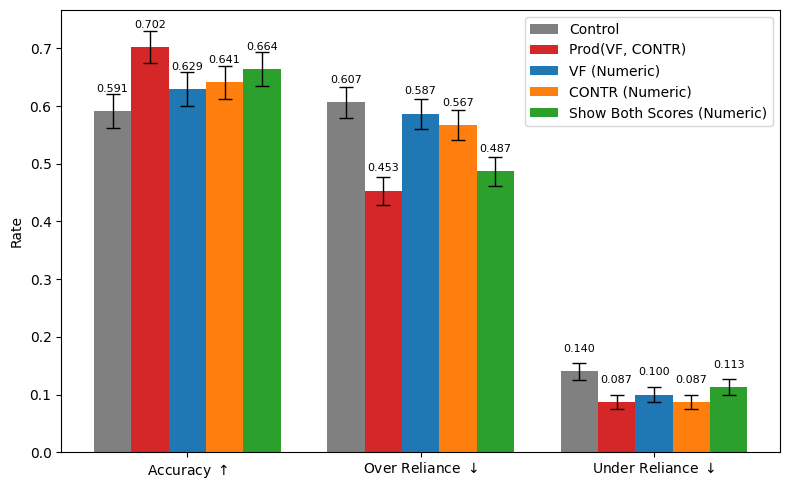

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 1) configure which variants + human names you want
variants      = num_setting_variants
names         = num_setting_names

# 2) the metric columns and their SE columns, in the order you want them on the x‑axis
metrics       = ['NotUnsureAcc', 'False Acp Rate', 'False Rej Rate']
se_cols       = ['NotUnsureAcc SE', 'FalseAcp SE', 'FalseRej SE']
pretty_labels = [r'Accuracy $\uparrow$', r'Over Reliance $\downarrow$', r'Under Reliance $\downarrow$']

# 3) pull out a tiny DataFrame of shape (3 metrics × N conditions)
data   = summary_df.loc[variants, metrics].T        # rows=metrics, cols=variants
errors = summary_df.loc[variants, se_cols].T        # same shape

# 4) build the clustered bar chart “by hand” so we can control everything
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(metrics))                         # 0,1,2
total_width = 0.8
n = len(variants)
bar_width = total_width / n

for i, (var, label) in enumerate(zip(variants, names)):
    vals = data[var].values
    errs = errors[var].values
    # center each group at x, then shift for each variant
    xpos = x - total_width/2 + bar_width/2 + i*bar_width
    # Replace "Metric" in the label with "Score"
    label = label.replace("Metric", "Score")

    # draw the bar
    ax.bar(xpos, vals, bar_width,
           color=group_colors.get(var.split('_')[0], 'gray'),
        #    alpha=1.0 if ('numeric' in var or var.startswith('prodmetric')) else 0.5,
           label=label)

    # draw the error‐bars
    ax.errorbar(xpos, vals, yerr=errs,
                fmt='none',         # no additional marker
                capsize=5,
                elinewidth=1,
                ecolor='black')

    # add floating labels
    for xi, yi in zip(xpos, vals):
        ax.text(xi, yi + 0.03, f"{yi:.3f}",
                ha='center', va='bottom', fontsize=8)

# finish styling
ax.set_xticks(x)
ax.set_xticklabels(pretty_labels, rotation=0)
ax.set_ylabel("Rate")
# ax.set_title("Accuracy / Over Reliance / Under Reliance by Condition")
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

def plot_numeric_vs_descriptive(
    metric_name: str,
    metric_se_name: str = None,
    y_lim_max: float = None,
    summary_df=None,
    group_colors=None,
    suffix: str = '_llava1.5_aokvqa_better_sampled_q10_i10_s0',
    figsize: tuple = (6, 4),
    n_per_group: int = 300  # <-- how many annotations in each numeric / descriptive arm
):
    # original groups (we still use these to look up variants)
    groups = ['vf', 'contr', 'showbothmetrics']
    group_labels = ['VF', 'CONTR', 'Show Both Metrics']
    n_groups = len(groups)
    
    bar_width = 0.4
    
    # build variant names
    num_variants = [f"{g}_numeric{suffix}" for g in groups]
    # special-case rename
    num_variants = [
        (f"showbothmetrics{suffix}" if name == f"showbothmetrics_numeric{suffix}"
         else name)
        for name in num_variants
    ]
    desc_variants = [f"{g}_descriptive{suffix}" for g in groups]
    control_variant = f"combined12{suffix}"
    
    x_all      = np.arange(n_groups + 1)
    x_ctrl     = x_all[0]
    x_groups   = x_all[1:]
    all_labels = ['Control'] + group_labels
    
    fig, ax = plt.subplots(figsize=figsize)
    
    r_ctrl = summary_df.loc[control_variant, metric_name]
    e_ctrl = (summary_df.loc[control_variant, metric_se_name]
              if metric_se_name else None)
    
    for i, grp in enumerate(groups):
        xpos = x_groups[i]
        # rates
        r_num  = summary_df.loc[num_variants[i], metric_name]
        r_desc = summary_df.loc[desc_variants[i], metric_name]
        # errors (or zeros if none)
        e_num  = summary_df.loc[num_variants[i], metric_se_name] if metric_se_name else None
        e_desc = summary_df.loc[desc_variants[i], metric_se_name] if metric_se_name else None

        color = group_colors.get(grp, 'gray')
        
        # numeric
        ax.bar(
            xpos - bar_width/2, r_num,
            width=bar_width,
            yerr=e_num,
            color=color,
            alpha=1.0,
            error_kw={'capsize':5, 'elinewidth':1},
            label='Numeric' if i == 0 else ""
        )
        # descriptive
        ax.bar(
            xpos + bar_width/2, r_desc,
            width=bar_width,
            yerr=e_desc,
            color=color,
            alpha=0.5,
            error_kw={'capsize':5, 'elinewidth':1},
            label='Descriptive' if i == 0 else ""
        )
    # control bar
    # plot the single control bar at the far left
    ax.bar(
        x_ctrl, r_ctrl,
        width=bar_width,
        yerr=e_ctrl,
        color='gray',
        alpha=1.0,
        error_kw={'capsize':5, 'elinewidth':1},
        label='_nolegend_'
    )
    
    # annotate each bar with its height
    for container in ax.containers:
        if hasattr(container, "patches"):
            ax.bar_label(container, fmt="%.3f", padding=3)
    
    # formatting
    ax.set_xticks(x_all)
    ax.set_xticklabels(all_labels)
    ax.set_ylabel(metric_name)
    if y_lim_max is not None:
        ax.set_ylim(0, y_lim_max)
    ax.set_title(f"{metric_name}: Numeric vs Descriptive")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # --- significance testing ---
    print("\nTwo‐proportion z‐tests (H₀: numeric = descriptive):")
    for i, grp in enumerate(groups):
        r_num  = summary_df.loc[num_variants[i], metric_name]
        r_desc = summary_df.loc[desc_variants[i], metric_name]
        count_num  = int(round(r_num  * n_per_group))
        count_desc = int(round(r_desc * n_per_group))
        counts = np.array([count_num, count_desc])
        nobs   = np.array([n_per_group, n_per_group])
        
        z_stat, p_val = proportions_ztest(counts, nobs)
        print(f"  {group_labels[i]:<16} Δ={r_num-r_desc: .3f}   z={z_stat: .2f}   p={p_val: .3f}")


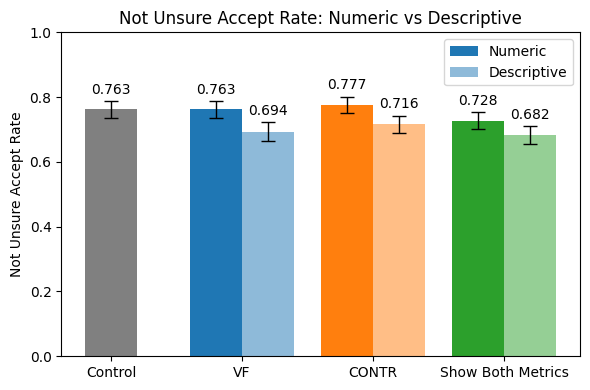


Two‐proportion z‐tests (H₀: numeric = descriptive):
  VF               Δ= 0.069   z= 1.93   p= 0.054
  CONTR            Δ= 0.060   z= 1.69   p= 0.091
  Show Both Metrics Δ= 0.045   z= 1.16   p= 0.245


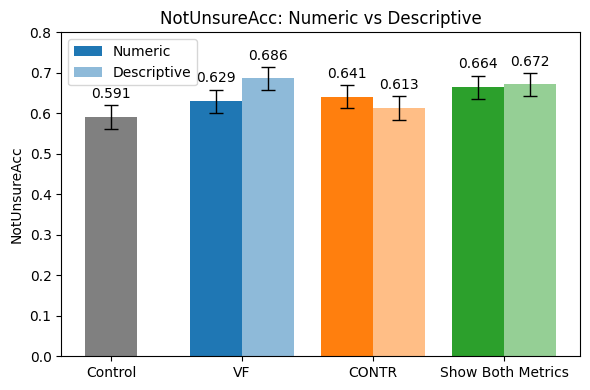


Two‐proportion z‐tests (H₀: numeric = descriptive):
  VF               Δ=-0.057   z=-1.46   p= 0.143
  CONTR            Δ= 0.028   z= 0.68   p= 0.500
  Show Both Metrics Δ=-0.007   z=-0.17   p= 0.862


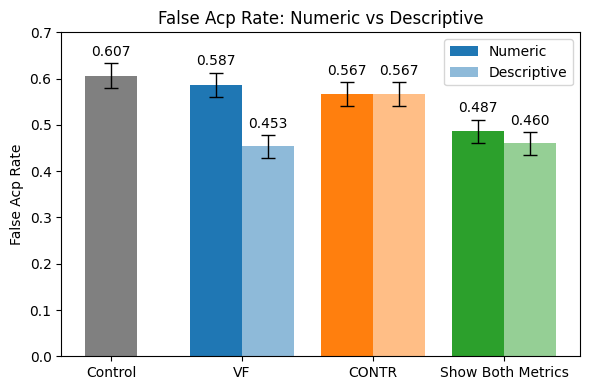


Two‐proportion z‐tests (H₀: numeric = descriptive):
  VF               Δ= 0.133   z= 3.27   p= 0.001
  CONTR            Δ= 0.000   z= 0.00   p= 1.000
  Show Both Metrics Δ= 0.027   z= 0.65   p= 0.513


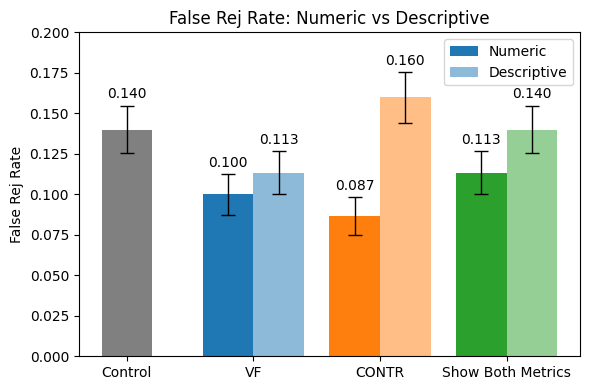


Two‐proportion z‐tests (H₀: numeric = descriptive):
  VF               Δ=-0.013   z=-0.53   p= 0.597
  CONTR            Δ=-0.073   z=-2.73   p= 0.006
  Show Both Metrics Δ=-0.027   z=-0.98   p= 0.326


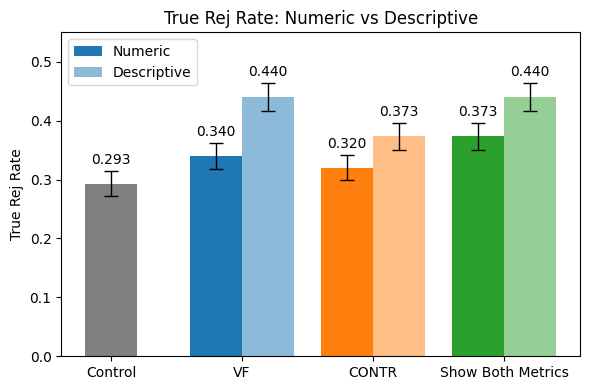


Two‐proportion z‐tests (H₀: numeric = descriptive):
  VF               Δ=-0.100   z=-2.51   p= 0.012
  CONTR            Δ=-0.053   z=-1.37   p= 0.170
  Show Both Metrics Δ=-0.067   z=-1.66   p= 0.096


In [8]:
plot_numeric_vs_descriptive(
    metric_name='Not Unsure Accept Rate',
    metric_se_name='NotUnsureAccept SE',
    y_lim_max=1,
    summary_df=summary_df,
    group_colors=group_colors
)

plot_numeric_vs_descriptive(
    metric_name='NotUnsureAcc',
    metric_se_name='NotUnsureAcc SE',
    y_lim_max=0.8,
    summary_df=summary_df,
    group_colors=group_colors
)

plot_numeric_vs_descriptive(
    metric_name='False Acp Rate',
    metric_se_name='FalseAcp SE',
    y_lim_max=0.7,
    summary_df=summary_df,
    group_colors=group_colors
)

plot_numeric_vs_descriptive(
    metric_name='False Rej Rate',
    metric_se_name='FalseRej SE',
    y_lim_max=0.2,
    summary_df=summary_df,
    group_colors=group_colors
)
plot_numeric_vs_descriptive(
    metric_name='True Rej Rate',
    metric_se_name='TrueRej SE',
    y_lim_max=0.55,
    summary_df=summary_df,
    group_colors=group_colors
)

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings to compare ---
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
    'vf_numeric_qwen2.5_vizwiz_q10_i10_s0',
    'vf_descriptive_qwen2.5_vizwiz_q10_i10_s0',
]

records = []
for setting in settings:
    df = df_map[setting]
    for idx, row in df.iterrows():
        queue_name = "qwen2.5_vizwiz_q10_i10_s0" if 'vizwiz' in setting else "llava1.5_with_image_q20_i10_s0"
        # get the batch ID (e.g. '000' from '000_3users')
        batch_id = row['batch'].split('_')[0]
        path = f'../web/baked_queues/{queue_name}/{batch_id}.json'
        if not os.path.exists(path):
            continue

        # load the questions for this batch
        with open(path) as f:
            questions = json.load(f)
        entry = questions[row['question_i']]

        vf   = entry.get('visual_fidelity')
        ctr  = entry.get('contrastiveness')
        avg  = None if vf is None or ctr is None else (vf + ctr) / 2

        # pick which score was shown
        if 'avg_vf_contr' in setting:
            confidence = avg
        elif setting.startswith('vf'):
            confidence = vf
        elif setting.startswith('contr'):
            confidence = ctr
        else:
            condidence = None
        # add to df
        df.loc[idx, 'confidence'] = confidence
    
df_map['vf_numeric_llava1.5_with_image_q20_i10_s0']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# mapping from your raw column names to nice labels
stage_map = {
    'answeronly': 'Answer Only',
    'withexplanation': 'With Explanation',
    'withexplanationquality': 'With Explanation + Quality'
}

selection_order = [0, 1, 2]
colors = ['tab:green', 'tab:red', 'tab:orange']
stage_order = list(stage_map.values())

for setting, df in df_map.items():
    # 1) melt into long form
    df_long = df.melt(
        id_vars=['user_id', 'batch', 'question_i', 'ground_truth'],
        value_vars=list(stage_map.keys()),
        var_name='Stage',
        value_name='Selection'
    )
    # 2) map raw to pretty
    df_long['Stage'] = df_long['Stage'].map(stage_map)

    # 3) group + count
    grouped = (
        df_long
        .groupby('Stage')['Selection']
        .value_counts()
        .unstack(fill_value=0)
        .reindex(index=stage_order, columns=selection_order)
    )

    # 4) plot stacked bar
    fig, ax = plt.subplots(figsize=(6, 8))
    x = np.arange(len(stage_order))
    bottom = np.zeros(len(stage_order))

    for sel, color in zip(selection_order, colors):
        counts = grouped[sel].values
        legend_label = f"Correct" if sel == 0 else f"Incorrect" if sel == 1 else "Unsure"
        bars = ax.bar(x, counts, bottom=bottom,
                      label=legend_label,
                      color=color, edgecolor='black')
        # annotate counts
        for idx, bar in enumerate(bars):
            h = bar.get_height()
            if h:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bottom[idx] + h/2,
                    f"{int(h)}",
                    ha='center', va='center'
                )
        bottom += counts

    ax.set_xticks(x)
    ax.set_xticklabels(stage_order, fontsize=12, rotation=30)
    ax.set_xlabel("Stage", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"Selection Counts by Stage ({setting.split('_llava')[0].split('_vizwiz')[0]})",
                 fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# mapping from your raw column names to nice labels
stage_map = {
    'answeronly': 'Answer Only',
    'withexplanation': 'With Explanation',
    'withexplanationquality': 'With Explanation + Quality'
}

selection_order = [0, 1, 2]
colors = ['tab:green', 'tab:red', 'tab:orange']
stage_order = list(stage_map.values())

for setting, df in df_map.items():
    # 1) melt into long form
    df_long = df.melt(
        id_vars=['user_id', 'batch', 'question_i', 'ground_truth'],
        value_vars=list(stage_map.keys()),
        var_name='Stage',
        value_name='Selection'
    )
    # 2) map raw to pretty
    df_long['Stage'] = df_long['Stage'].map(stage_map)

    # 3) compute u_i
    #   u_i = 0 if Selection == 2
    #   u_i = 1 if (sel=1 & gt=0) or (sel=0 & gt=1)
    #   u_i = -1 otherwise (i.e. sel matches gt)
    df_long['u_i'] = np.where(
        df_long['Selection'] == 2, 0,
        np.where(
            ((df_long['Selection'] == 1) & (df_long['ground_truth'] == 1)) |
            ((df_long['Selection'] == 0) & (df_long['ground_truth'] == 0)),
            1,
            -1
        )
    )

    # inspect the new column
    print(f"\n—— {setting} ——")
    # randomly sample 5 rows
    print(df_long[['Stage', 'Selection', 'ground_truth', 'u_i']].sample(5))

    # now group & plot u_i
    u_order  = [1, -1, 0]                     # mismatch, unsure, match
    u_colors = ['tab:green', 'tab:red', 'tab:orange',]
    u_labels = ['Match (+1)', 'Mismatch (-1)', 'Unsure (0)',]

    grouped = (
        df_long
        .groupby('Stage')['u_i']
        .value_counts()
        .unstack(fill_value=0)
        .reindex(index=stage_order, columns=u_order)
    )

    fig, ax = plt.subplots(figsize=(6, 8))
    x = np.arange(len(stage_order))
    bottom = np.zeros(len(stage_order))

    for u, color, label in zip(u_order, u_colors, u_labels):
        counts = grouped[u].values
        bars = ax.bar(x, counts, bottom=bottom, label=label,
                    color=color, edgecolor='black')
        for idx, bar in enumerate(bars):
            h = bar.get_height()
            if h:
                ax.text(bar.get_x() + bar.get_width()/2,
                        bottom[idx] + h/2,
                        f"{int(h)}",
                        ha='center', va='center')
        bottom += counts

    ax.set_xticks(x)
    ax.set_xticklabels(stage_order, fontsize=12, rotation=30)
    ax.set_xlabel("Stage", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"Answer Correctness by Stage ({setting.split('_llava')[0].split('_vizwiz')[0]})",
                fontsize=16)
    ax.legend(fontsize=12, title="Correctness", loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter

# --- your existing mappings & lists ---
stage_map = {
    'answeronly': 'Answer Only',
    'withexplanation': 'With Explanation',
    'withexplanationquality': 'With Explanation + Quality'
}
selection_order = [0, 1, 2]
colors = ['tab:green', 'tab:red', 'tab:orange']
labels = {
    0: 'Correct',
    1: 'Incorrect',
    2: 'Unsure'
}
applied_settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
]
applied_setting_names = {
    'vf_numeric_llava1.5_with_image_q20_i10_s0': 'VF Numeric',
    'contr_numeric_llava1.5_with_image_q20_i10_s0': 'CONTR Numeric',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0': 'Average VF/CONTR',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0': 'Both Metrics',
}

# 1) Melt & compute u_i for all settings (same as before) …
all_dfs = []
for setting, df in df_map.items():
    if setting not in applied_settings:
        continue
    df_long = df.melt(
        id_vars=['user_id','batch','question_i','ground_truth'],
        value_vars=list(stage_map.keys()),
        var_name='Stage', value_name='Selection'
    )
    df_long['Stage'] = df_long['Stage'].map(stage_map)
    df_long['Setting'] = setting

    all_dfs.append(df_long)
big = pd.concat(all_dfs, ignore_index=True)

# 2a) Overall Stage 2 (“With Explanation”)
agg2 = (big.loc[big['Stage']=='With Explanation','Selection']
          .value_counts()
          .reindex(selection_order, fill_value=0))
agg2_prop = agg2 / agg2.sum()

# 2b) Stage 3 (“With Explanation + Quality”) per setting
stage3 = big[big['Stage']=='With Explanation + Quality']
by_set = (stage3.groupby('Setting')['Selection']
               .value_counts()
               .unstack(fill_value=0)
               .reindex(columns=selection_order, fill_value=0))
by_set_prop = by_set.div(by_set.sum(axis=1), axis=0)

# 3) Build combined_prop in the exact order: Overall, then each applied_setting
rows = [agg2_prop] + [by_set_prop.loc[s] for s in applied_settings]
index = ['Overall'] + applied_settings
combined_prop = pd.DataFrame(rows, index=index, columns=selection_order)

# 4) Plot them with tighter bars
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(combined_prop))
width = 0.8   
bottom = np.zeros(len(combined_prop))

for u, color in zip(selection_order, colors):
    vals = combined_prop[u]
    bars = ax.bar(x, vals, width, bottom=bottom,
                  color=color, label=labels[u], edgecolor='k')
    for xi, (bar, v) in enumerate(zip(bars, vals)):
        if v > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bottom[xi] + v/2,
                f"{v:.1%}",
                ha='center', va='center'
            )
    bottom += vals

# 5) Force x‑labels in the same exact order
ax.set_xticks(x)
ax.set_xticklabels(
    ['With Explanation'] +
    [applied_setting_names[s] for s in applied_settings],
    rotation=30, ha='right'
)

ax.margins(x=0.02)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('User Selection Across Settings', fontsize=16)
ax.legend(title='Selection', loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter

# --- your existing mappings & lists ---
stage_map = {
    'answeronly': 'Answer Only',
    'withexplanation': 'With Explanation',
    'withexplanationquality': 'With Explanation + Quality'
}
selection_order = [1, -1, 0]
colors = ['tab:green', 'tab:red', 'tab:orange']
labels = {
    1: 'Match (+1)',
   -1: 'Mismatch (-1)',
    0: 'Unsure (0)'
}
applied_settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
]
applied_setting_names = {
    'vf_numeric_llava1.5_with_image_q20_i10_s0': 'VF Numeric',
    'contr_numeric_llava1.5_with_image_q20_i10_s0': 'CONTR Numeric',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0': 'Average VF/CONTR',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0': 'Both Metrics',
}

# 1) Melt & compute u_i for all settings (same as before) …
all_dfs = []
for setting, df in df_map.items():
    if setting not in applied_settings:
        continue
    df_long = df.melt(
        id_vars=['user_id','batch','question_i','ground_truth'],
        value_vars=list(stage_map.keys()),
        var_name='Stage', value_name='Selection'
    )
    df_long['Stage'] = df_long['Stage'].map(stage_map)
    df_long['Setting'] = setting
    df_long['u_i'] = np.where(
        df_long['Selection']==2, 0,
        np.where(
            ((df_long['Selection']==1)&(df_long['ground_truth']==1)) |
            ((df_long['Selection']==0)&(df_long['ground_truth']==0)),
            1,
            -1
        )
    )
    all_dfs.append(df_long)
big = pd.concat(all_dfs, ignore_index=True)

# 2a) Overall Stage 2 (“With Explanation”)
agg2 = (big.loc[big['Stage']=='With Explanation','u_i']
          .value_counts()
          .reindex(selection_order, fill_value=0))
agg2_prop = agg2 / agg2.sum()

# 2b) Stage 3 (“With Explanation + Quality”) per setting
stage3 = big[big['Stage']=='With Explanation + Quality']
by_set = (stage3.groupby('Setting')['u_i']
               .value_counts()
               .unstack(fill_value=0)
               .reindex(columns=selection_order, fill_value=0))
by_set_prop = by_set.div(by_set.sum(axis=1), axis=0)

# 3) Build combined_prop in the exact order: Overall, then each applied_setting
rows = [agg2_prop] + [by_set_prop.loc[s] for s in applied_settings]
index = ['Overall'] + applied_settings
combined_prop = pd.DataFrame(rows, index=index, columns=selection_order)

# 4) Plot them with tighter bars
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(combined_prop))
width = 0.8   
bottom = np.zeros(len(combined_prop))

for u, color in zip(selection_order, colors):
    vals = combined_prop[u]
    bars = ax.bar(x, vals, width, bottom=bottom,
                  color=color, label=labels[u], edgecolor='k')
    for xi, (bar, v) in enumerate(zip(bars, vals)):
        if v > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bottom[xi] + v/2,
                f"{v:.1%}",
                ha='center', va='center'
            )
    bottom += vals

# 5) Force x‑labels in the same exact order
ax.set_xticks(x)
ax.set_xticklabels(
    ['With Explanation'] +
    [applied_setting_names[s] for s in applied_settings],
    rotation=30, ha='right'
)

ax.margins(x=0.02)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Answer Correctness by Setting (in %)', fontsize=16)
ax.legend(title='Correctness', loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
for setting, df in df_map.items():
    df['utility_2'] = np.where(
        df['withexplanation'] == 2, 0,
        np.where(
            ((df['withexplanation'] == 1) & (df['ground_truth'] == 1)) |
            ((df['withexplanation'] == 0) & (df['ground_truth'] == 0)),
            1,
            -1
        )
    )
    df['utility_3'] = np.where(
        df['withexplanationquality'] == 2, 0,
        np.where(
            ((df['withexplanationquality'] == 1) & (df['ground_truth'] == 1)) |
            ((df['withexplanationquality'] == 0) & (df['ground_truth'] == 0)),
            1,
            -1
        )
    )
df_map['vf_numeric_llava1.5_with_image_q20_i10_s0'].sample(10)


In [ ]:
# 2) Compute M2–M4 using utility, for each applied setting
all_scores = []
for setting in applied_settings:
    df = df_map[setting]
    
    # M2: Positive conversion rate
    #    P(u3 = +1 | u2 = 0, u3 != 0)
    mask2 = (df['utility_2'] == 0) & (df['utility_3'] != 0)
    m2 = (df.loc[mask2, 'utility_3'] == 1).sum() / mask2.sum()
    
    # M3: Error recovery rate
    #    P(u3 >= 0 | u2 < 0)
    mask3 = df['utility_2'] < 0
    m3 = (df.loc[mask3, 'utility_3'] >= 0).sum() / mask3.sum()
    
    # M4: Correct loss rate
    #    P(u3 <= 0 | u2 > 0)
    mask4 = df['utility_2'] > 0
    m4 = (df.loc[mask4, 'utility_3'] <= 0).sum() / mask4.sum()
    
    all_scores.append({
        'Setting': applied_setting_names[setting],
        'Positive Conversion': m2,
        'Error Recovery': m3,
        'Correct Loss': m4
    })

# 3) Build DataFrame and plot grouped bar chart
df_scores = pd.DataFrame(all_scores).set_index('Setting')

ax = df_scores.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.6,
    edgecolor='k'
)
ax.set_xlabel('Setting', fontsize=16)
ax.set_ylabel('Rate', fontsize=18)
ax.set_ylim(0, 1)
ax.set_title('Correctness Change Measures Across Settings', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
ax.legend(title='Metric', loc='upper right', fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.show()

# 4) Group by metric on the x‑axis instead of by setting
#    i.e. transpose so rows become metrics and columns become settings
df_scores_T = df_scores.transpose()

ax = df_scores_T.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.6,
    edgecolor='k'
)
ax.set_xlabel('Metric', fontsize=16)
ax.set_ylabel('Rate', fontsize=18)
ax.set_title('Correctness Change Measures', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
ax.legend(title='Setting', loc='upper right', fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# 5) Plot M3 (Error Recovery) for VF Numeric vs VF Descriptive
# -------------------------------------------------------------

numeric_descriptive_settings_pair = [
    ['vf_numeric_llava1.5_with_image_q20_i10_s0', 'vf_descriptive_llava1.5_with_image_q20_i10_s0'],
    ['contr_numeric_llava1.5_with_image_q20_i10_s0', 'contr_descriptive_llava1.5_with_image_q20_i10_s0'],
    ['showbothmetrics_llava1.5_with_image_q20_i10_s0', 'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0'],
]

# Define group labels
group_labels = ['VF', 'CONTR', 'Both']

# Compute M3 for each group
m3_dict = {}
for label, (num_s, des_s) in zip(group_labels, numeric_descriptive_settings_pair):
    df_num = df_map[num_s]
    df_des = df_map[des_s]
    
    mask_num = df_num['utility_2'] < 0
    mask_des = df_des['utility_2'] < 0
    
    m3_num = (df_num.loc[mask_num, 'utility_3'] >= 0).sum() / mask_num.sum()
    m3_des = (df_des.loc[mask_des, 'utility_3'] >= 0).sum() / mask_des.sum()
    
    m3_dict[label] = {'Numeric': m3_num, 'Descriptive': m3_des}

# Build DataFrame
m3_df = pd.DataFrame.from_dict(m3_dict, orient='index')

# Plot grouped bars
fig, ax = plt.subplots(figsize=(8, 5))
m3_df.plot(
    kind='bar',
    ax=ax,
    width=0.6,
    edgecolor='k'
)

# Tighten spacing
ax.margins(x=0.02)

# Labels and title
ax.set_ylabel('Error Recovery Rate', fontsize=16)
# ax.set_ylim(0, 1)
ax.set_title('Error Recovery Rate by Numeric vs Descriptive', fontsize=14)
ax.set_xticklabels(group_labels, rotation=0, fontsize=16)

# Annotate bar values
for i, row_label in enumerate(group_labels):
    for j, col_label in enumerate(['Numeric', 'Descriptive']):
        v = m3_df.loc[row_label, col_label]
        ax.text(i + (j-0.5)*0.3, v, f"{v:.1%}",
                ha='center', va='bottom', fontsize=10)

# Legend
ax.legend(title='Format', loc='upper left')

plt.tight_layout()
plt.show()

# Compute M4 for each group
m4_dict = {}
for label, (num_s, des_s) in zip(group_labels, numeric_descriptive_settings_pair):
    df_num = df_map[num_s]
    df_des = df_map[des_s]
    
    mask_num = df_num['utility_2'] > 0
    mask_des = df_des['utility_2'] > 0
    
    m4_num = (df_num.loc[mask_num, 'utility_3'] <= 0).sum() / mask_num.sum()
    m4_des = (df_des.loc[mask_des, 'utility_3'] <= 0).sum() / mask_des.sum()
    
    m4_dict[label] = {'Numeric': m4_num, 'Descriptive': m4_des}
# Build DataFrame
m4_df = pd.DataFrame.from_dict(m4_dict, orient='index')
# Plot grouped bars
fig, ax = plt.subplots(figsize=(8, 5))
m4_df.plot(
    kind='bar',
    ax=ax,
    width=0.6,
    edgecolor='k'
)
# Tighten spacing
ax.margins(x=0.02)
# Labels and title
ax.set_ylabel('Correct Loss Rate', fontsize=16)
# ax.set_ylim(0, 1)
ax.set_title('Correct Loss Rate by Numeric vs Descriptive', fontsize=14)
ax.set_xticklabels(group_labels, rotation=0, fontsize=16)
# Annotate bar values
for i, row_label in enumerate(group_labels):
    for j, col_label in enumerate(['Numeric', 'Descriptive']):
        v = m4_df.loc[row_label, col_label]
        ax.text(i + (j-0.5)*0.3, v, f"{v:.1%}",
                ha='center', va='bottom', fontsize=10)
# Legend
ax.legend(title='Format', loc='upper left')
plt.tight_layout()
plt.show()
# Compute M5 (Recovery Gap) correctly for each group
m5_dict = {}
for label, (num_s, des_s) in zip(group_labels, numeric_descriptive_settings_pair):
    df_num = df_map[num_s]
    df_des = df_map[des_s]
    
    # Mask for error cases (u2 < 0) and for correct cases (u2 > 0)
    mask_num_neg = df_num['utility_2'] < 0
    mask_num_pos = df_num['utility_2'] > 0
    mask_des_neg = df_des['utility_2'] < 0
    mask_des_pos = df_des['utility_2'] > 0
    
    # M3_num on negative mask, M4_num on positive mask
    m3_num = (df_num.loc[mask_num_neg, 'utility_3'] >= 0).sum()   / mask_num_neg.sum()
    m4_num = (df_num.loc[mask_num_pos, 'utility_3'] <= 0).sum()   / mask_num_pos.sum()
    
    # same for descriptive
    m3_des = (df_des.loc[mask_des_neg, 'utility_3'] >= 0).sum()   / mask_des_neg.sum()
    m4_des = (df_des.loc[mask_des_pos, 'utility_3'] <= 0).sum()   / mask_des_pos.sum()
    
    m5_dict[label] = {
        'Numeric': m3_num - m4_num,
        'Descriptive': m3_des - m4_des
    }

# Build and plot as before
m5_df = pd.DataFrame.from_dict(m5_dict, orient='index')
ax = m5_df.plot(kind='bar', figsize=(8,5), width=0.6, edgecolor='k')
ax.margins(x=0.02)
ax.set_ylabel('Recovery Gap', fontsize=16)
ax.set_title('Recovery Gap by Numeric vs Descriptive', fontsize=14)
ax.set_xticklabels(group_labels, rotation=0, fontsize=16)
for i, row_label in enumerate(group_labels):
    for j, col_label in enumerate(['Numeric','Descriptive']):
        v = m5_df.loc[row_label, col_label]
        ax.text(i + (j-0.5)*0.3, v, f"{v:.1%}", ha='center', va='bottom', fontsize=10)
ax.legend(title='Format', loc='upper left')
plt.tight_layout()
plt.show()




In [ ]:
# Plot the confidence distributions for each setting
for setting in settings:
    df = df_map[setting]
    plt.figure(figsize=(5, 2))
    plt.hist(df['confidence'], bins=20, alpha=0.7, label=setting)
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title(f'Confidence Distribution for {setting}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

def bin_stats(df, not_wanted_value):
    n = len(df)
    if n == 0:
        return pd.Series({'p': 0, 'se': 0, 'n': 0})
    k = (df['withexplanationquality'] != not_wanted_value).sum()
    p = k / n
    # Laplace-smoothed se
    p_ = (k + 1) / (n + 2)
    se_ = sqrt(p_ * (1 - p_) / (n + 2))
    return pd.Series({'p': p, 'se': se_, 'n': n})

# colors for each selection
color_map = {0: 'C0', 1: 'tab:green', 2: 'tab:orange'}

for setting, df in df_map.items():
    if setting not in settings:
        continue

    # choose metric label
    if 'avg_vf_contr' in setting:
        confidence_metric = 'AVERAGE(VF, CONTR)'
    elif setting.startswith('vf'):
        confidence_metric = 'VF'
    elif setting.startswith('contr'):
        confidence_metric = 'CONTR'
    else:
        confidence_metric = ''

    # bin edges
    n_bins = 5
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0]) * 0.9
    
    df['conf_bin'] = pd.cut(
        df['confidence'],
        bins=bin_edges,
        include_lowest=True,  # makes 0.0 go into the first bin
        right=True            # makes 1.0 go into the last bin
    )

    # make 3 subplots
    fig, axes = plt.subplots(
        1, 3,
        figsize=(12, 4),
        sharey=True
    )

    for ax, sel in zip(axes, [0, 1, 2]):
        df0 = df[df['withexplanation'] == sel]
        grouped = (
            df0
            .groupby('conf_bin', observed=False)
            .apply(lambda g: bin_stats(g, sel))
            .reset_index()
        )
        # to percentages
        grouped['p']  *= 100
        grouped['se'] *= 100

        ax.bar(
            bin_centers,
            grouped['p'],
            width=width,
            yerr=grouped['se'],
            capsize=5,
            edgecolor='black',
            color=color_map[sel]
        )
        # annotate counts on top of each bar
        for x, height, count in zip(bin_centers, grouped['p'], grouped['n']):
            ax.text(
                x, 
                height + 1,              # small vertical offset
                f'n={int(count)}',
                ha='center', 
                va='bottom',
                fontsize='small'
            )
                
        # ---------------------------------------------------------------
        # Weighted Linear Regression using WLS (weights = counts, n)
        # ---------------------------------------------------------------
        x_data = bin_centers
        y_data = grouped['p']
        weights = grouped['n']
        
        # Remove potential bins with zero counts, which could be problematic
        valid = weights > 0
        x_valid = x_data[valid]
        y_valid = y_data[valid]
        weights_valid = weights[valid]
        
        # Only regress if we have 2+ points
        if len(x_valid) > 1:
            X = sm.add_constant(x_valid)
            wls_model = sm.WLS(y_valid, X, weights=weights_valid)
            results = wls_model.fit()
            intercept, slope = results.params
            slope_se = results.bse[1]  # standard error of slope
            # Create line for plotting
            x_line = np.linspace(min(x_valid), max(x_valid), 50)
            y_line = slope * x_line + intercept
            ax.plot(
                x_line, y_line,
                color='red', linestyle='--',
                label=(f"y = {slope:.2f}x + {intercept:.2f}\n"
                    f"Slope SE = {slope_se:.2f}")
            )

            ax.legend(fontsize='small')

        # ---------------------------------------------------------------
        

        ax.set_title(f's₂ == {sel}')
        ax.set_xlabel(f'Confidence ({confidence_metric})')
        ax.set_xlim(0, 1)


        
    axes[0].set_ylabel(f'P(s₃ ≠ s₂ ∣ s₂ == {{0,1,2}}) [%]')
    axes[0].set_ylim(0, 100)
    plt.suptitle(f"Setting: {setting}")
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()


In [ ]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def bin_stats(df, not_wanted_value):
    n = len(df)
    if n == 0:
        return pd.Series({'p': 0, 'se': 0, 'n': 0})
    k = (df['withexplanationquality'] != not_wanted_value).sum()
    p = k / n
    # Laplace-smoothed standard error
    p_ = (k + 1) / (n + 2)
    se_ = sqrt(p_ * (1 - p_) / (n + 2))
    return pd.Series({'p': p, 'se': se_, 'n': n})

metrics_to_plot = ['vf_numeric_llava1.5_with_image_q20_i10_s0', 'vf_descriptive_llava1.5_with_image_q20_i10_s0']
metric_colors = {'VF_numeric': 'C0', 'VF_descriptive': 'C1'}
# a simple mapping from your metric‐IDs to pretty legend labels
label_map = {
    'vf_numeric_llava1.5_with_image_q20_i10_s0': 'VF numeric',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0': 'VF descriptive',
}

n_bins = 5
bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# Loop over the s₂ values – here using withexplanation == 0, 1, 2
for ax, sel in zip(axes, [0, 1, 2]):
    # For each s₂ subplot, plot both metrics on the same axes
    for metric in metrics_to_plot:
        # Get the corresponding DataFrame from df_map.
        # (For safety, we use a copy since we will add a new column.)
        df = df_map[metric].copy()
        # Bin the confidence values (you can adjust include_lowest/right as appropriate)
        df['conf_bin'] = pd.cut(
            df['confidence'],
            bins=bin_edges,
            include_lowest=True,
            right=True
        )
        
        # Select the data for the current s₂ value
        df0 = df[df['withexplanation'] == sel]
        
        # Group by confidence bin and calculate proportion (p), laplace-smoothed se, and count (n)
        grouped = (df0.groupby('conf_bin', observed=False)
                    .apply(lambda g: bin_stats(g, sel))
                    .reset_index())
        # (Optional) make sure that the results are ordered by bin
        grouped = grouped.sort_values(by='conf_bin')
        
        # Convert proportions to percentages
        grouped['p'] *= 100
        grouped['se'] *= 100
        
        # Plot a line with markers and error bars using errorbar()
        ax.errorbar(
            bin_centers,
            grouped['p'],
            yerr=grouped['se'],
            marker='o',
            linestyle='-',
            color=metric_colors.get(metric, None),
            capsize=5,
            label=label_map[metric]
        )
        
        # annotate counts on top of each bar
        height_adjust = -1 if metric == 'vf_numeric_llava1.5_with_image_q20_i10_s0' else 4
        for x, height, count in zip(bin_centers, grouped['p'], grouped['n']):
            ax.text(
                x + 0.08,              # small horizontal offset
                height + height_adjust if height < 99 else height - 10 + height_adjust,              # small vertical offset
                f'n={int(count)}',
                ha='center',
                va='bottom',
                fontsize='small',
                color=metric_colors['VF_numeric'] if 'numeric' in metric else metric_colors['VF_descriptive']
            )
        

    title = f"s{sel}: "
    if sel == 0:
        title += "User thinks AI is Correct"
    elif sel == 1:
        title += "User thinks AI is Incorrect"
    elif sel == 2:
        title += "User is Unsure"
    ax.set_title(f'{title}')
    ax.set_xlabel('Confidence')
    ax.set_xlim(0, 1)
    # Set legend name
    # ax.legend(fontsize='small')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, fontsize='small')
axes[0].set_ylabel('Switch Rate at Stage 3 [%]', fontsize=14)
axes[0].set_ylim(0, 100)
plt.suptitle("After seeing explanation...", y=0.96)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
# Additional color mapping for compared metrics
compared_metric_colors = {
'vf_numeric_llava1.5_with_image_q20_i10_s0': 'C0',
'contr_numeric_llava1.5_with_image_q20_i10_s0': 'C2',
'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0': 'C3'
}

compared_metrics2 = ['vf_numeric_llava1.5_with_image_q20_i10_s0', 'contr_numeric_llava1.5_with_image_q20_i10_s0', 'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0']


# Update label_map if needed
label_map.update({
'contr_numeric_llava1.5_with_image_q20_i10_s0': 'Contr. numeric',
'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0': 'Avg VF Contr. numeric'
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

LABEL_PAD   = 2      # vertical step (points) you’re willing to move the label
MIN_SEP_Y   = 3      # how close two labels can be before we call it a collision
MIN_SEP_X   = 0.15   # so labels on different bars at same x don’t count
placed_xy   = []     # keeps track of every label we’ve already drawn

def find_free_y(x, y0):
    """
    Return the nearest y‑coordinate to y0 that is not 'too close' to any
    existing label.  We look up, then down, in LABEL_PAD‑point steps.
    """
    up_y   = y0
    down_y = y0
    # keep expanding the search ring until we find an empty slot
    while True:
        # try above first
        if not any(abs(up_y   - py) < MIN_SEP_Y and abs(x-px) < MIN_SEP_X for px, py in placed_xy):
            placed_xy.append((x, up_y))
            return up_y
        # then one step below
        if not any(abs(down_y - py) < MIN_SEP_Y and abs(x-px) < MIN_SEP_X for px, py in placed_xy):
            placed_xy.append((x, down_y))
            return down_y
        up_y   += LABEL_PAD
        down_y -= LABEL_PAD


# Loop over the s₂ values – here using withexplanation values 0, 1, 2
for ax, sel in zip(axes, [0, 1, 2]):
    # First, plot the original metrics
    for metric in compared_metrics2:
        df = df_map[metric].copy()
        df['conf_bin'] = pd.cut(
        df['confidence'],
        bins=bin_edges,
        include_lowest=True,
        right=True
        )
        df0 = df[df['withexplanation'] == sel]
        grouped = (df0.groupby('conf_bin', observed=False)
            .apply(lambda g: bin_stats(g, sel))
            .reset_index())
        grouped = grouped.sort_values(by='conf_bin')
        grouped['p'] *= 100
        grouped['se'] *= 100

        valid = grouped['n'] > 0
        ax.errorbar(
            bin_centers[valid],
            grouped.loc[valid, 'p'],
            yerr=grouped.loc[valid, 'se'],
            marker='o',
            linestyle='-',
            color=compared_metric_colors.get(metric, None),
            capsize=5,
            label=label_map[metric]
        )
        
        # annotate counts
        # ── 2. inside your loop that writes the labels ─────────────────────────────────
        for x, height, count in zip(bin_centers, grouped['p'], grouped['n']):
            if count == 0:
                continue
            # first decide the nominal y you would have used
            desired_y = height
            if height > 95:
                desired_y = height - 5
            elif height < 5:
                desired_y = height + 5

            
            # ask the helper for a collision‑free y position
            y_for_label = find_free_y(x + 0.08, desired_y)
            
            ax.text(
                x + 0.08,
                y_for_label,
                f'n={int(count)}',
                ha='center',
                va='bottom',
                fontsize='small',
                color=compared_metric_colors.get(metric, 'black')
            )

            
    # Set subplot titles and labels
    title = f"s{sel}: "
    if sel == 0:
        title += "User thinks AI is Correct"
    elif sel == 1:
        title += "User thinks AI is Incorrect"
    elif sel == 2:
        title += "User is Unsure"
    ax.set_title(title)
    ax.set_xlabel('Confidence')
    ax.set_xlim(0, 1)
    # ax.legend(fontsize='small')
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, fontsize='small')
axes[0].set_ylabel('Switch Rate at Stage 3 [%]', fontsize=14)
axes[0].set_ylim(0, 100) 
plt.suptitle("After seeing explanation...") 
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()